In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
# from pyomo.util.infeasible import log_infeasible_constraints
# import logging
# 
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.preprocessing import StandardScaler


In [21]:
# Basic Setting
this_day = '2050-05-06'
this_weekday = 'Friday'

In [40]:
# Utilization
date=6
def create_dict(row):
    dict = [0]*24
    for hour in range(24):
        if (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day==date)&(row['arr_hour']<hour): 
            dict[hour] = 60
        elif (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day<date):
            dict[hour] = 60
        elif (row['park_end_day']>date) & (row['arr_time'].day==date)&(row['arr_hour']<hour): 
            dict[hour] = 60
        elif (row['park_end_day']>date) & (row['arr_time'].day<date):
            dict[hour] = 60
        elif (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day==date)&(row['arr_hour']==hour): 
            dict[hour] = 60-row['arr_time'].minute
        elif  (row['park_end_day']>date) & (row['arr_hour']==hour)&(row['arr_time'].day==date):
            dict[hour] = 60-row['arr_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_hour']<hour) & (row['arr_time'].day==date):
            dict[hour] = row['park_end_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_time'].day<date):
            dict[hour] = row['park_end_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_hour']==hour) & (row['arr_time'].day==date):
            dict[hour] = row['park_end_time'].minute-row['arr_time'].minute
        else:
            dict[hour]=0
    return dict

def soe_init(row):
    soe_init={}
    for hour in range(24):
        if row['arr_time'].day<date:
            soe_init[hour] = row['SoE_bc']
        elif (hour<=row["arr_hour"]) and (row['arr_time'].day==date):
            soe_init[hour]=row['SoE_bc']
        else:
            soe_init[hour]=0
    return soe_init

def create_charge_time_list(row):
    charge_time_list = [0]*24
    if row['c']:
        st_chg = row['st_chg_time'].hour
        ed_chg = row['ed_chg_time'].hour
        for t in range(24):
            if (st_chg==t) & (ed_chg==t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = row['ed_chg_time'].minute-row['st_chg_time'].minute
            elif (st_chg<t) & (ed_chg>t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = 60
            elif (st_chg<t) & (ed_chg==t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = row['ed_chg_time'].minute
            elif (st_chg==t) & (((ed_chg>t) & (row['ed_chg_time'].day == date))|(row['ed_chg_time'].day>date)):
                charge_time_list[t] = 60-row['st_chg_time'].minute
            elif (st_chg<t) & (row['ed_chg_time'].day>date):
                charge_time_list[t]=60
            else:
                charge_time_list[t]=0
    return charge_time_list

In [41]:
df = pd.read_csv("/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/grid369_mobility_dataset.csv")
df['dep_time'] = pd.to_datetime(df['dep_time'],format='mixed')
df['arr_time'] = pd.to_datetime(df['arr_time'],format='mixed')
df['st_chg_time'] = pd.to_datetime(df['st_chg_time'],format='mixed')
df['ed_chg_time'] = pd.to_datetime(df['ed_chg_time'],format='mixed')
df['chg_time'] = pd.to_timedelta(df['ed_chg_time']-df['st_chg_time'],unit='m')

df['dep_hour'] = df['dep_time'].dt.hour
df['arr_hour'] = df['arr_time'].dt.hour
df.sort_values(by=['person','dep_time'])
df['next_travel_TP1_consumption'] = df.groupby('person')['TP1 consumption kWh'].shift(-1).fillna(0)

d = df[(df['grid'] == "369_0") & ((df['type_day'] == 'Thursday') | (df['type_day'] == 'Friday'))]
d['arr_time'] = d['dep_time'] + pd.to_timedelta(d['trav_time'], unit='m')
d.loc[d['type_day'] == 'Friday', 'arr_time'] = d.loc[d['type_day'] == 'Friday', 'arr_time'].apply(lambda dt: dt.replace(day=6, month=5, year=2050))
d.loc[d['type_day'] == 'Thursday', 'arr_time'] = d.loc[d['type_day'] == 'Thursday', 'arr_time'].apply(lambda dt: dt.replace(day=5, month=5, year=2050))
d['park_end_time'] = d['arr_time']+pd.to_timedelta(d['parking_time'],unit='m')
d['park_end_hour'] = d['park_end_time'].dt.hour
d['park_end_day'] = d['park_end_time'].dt.day
d.loc[:, 'st_chg_time'] = d.apply(lambda row: row['st_chg_time'].replace(day=row['arr_time'].day, month=row['arr_time'].month, year=row['arr_time'].year), axis=1)
d['ed_chg_time'] = d['st_chg_time']+d['chg_time']
d['chg_time'] = d['chg_time'].dt.total_seconds()/60
d = d[(d['park_end_time']>='2050-05-06 00:00:00') & (d['arr_time']<'2050-05-07 00:00:00')]
d.insert(0,'event_index',d.index)
d['max_chg_e'] = d['B']-d['SoE_bc']
d['real_chg_e'] = d['SoE_ac']-d['SoE_bc']
d['hourly_time_dict'] = d.apply(lambda x:create_dict(x), axis =1)
d['soe_init'] = d.apply(lambda x:soe_init(x), axis =1)
d['charge_time_list'] = d.apply(lambda x:create_charge_time_list(x), axis=1)
d['charge_power_list'] = d.apply(lambda x: [x['chg rate'] if t >30 else 0 for t in x['charge_time_list']], axis=1)
d['charge_energy_list'] = d.apply(lambda x:[t/60*x['chg rate']for t in x['charge_time_list']], axis=1)

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/691524322.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['arr_time'] = d['dep_time'] + pd.to_timedelta(d['trav_time'], unit='m')
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/691524322.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['park_end_time'] = d['arr_time']+pd.to_timedelta(d['parking_time'],unit='m')
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/691524322.py:18: SettingWithCopyWarnin

In [5]:
d.head(10)

,event_index,person,dep_time,trav_time,traveled_distance,start_activity_type,end_activity_type,start_x,start_y,end_x,...,park_end_time,park_end_hour,park_end_day,max_chg_e,real_chg_e,hourly_time_dict,soe_init,charge_time_list,charge_power_list,charge_energy_list
170,170,63620,2020-05-03 10:59:57,25.000000,30.753,work,leisure,2689194.0,1249241.0,2701360.0,...,2050-05-06 11:59:57.000000000,11,6,25.96,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0,...","{0: 94.04, 1: 94.04, 2: 94.04, 3: 94.04, 4: 94...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
313,313,94876,2020-05-03 13:32:23,66.400000,83.588,home,leisure,2724691.0,1220053.0,2697286.0,...,2050-05-06 16:32:23.000000000,16,6,34.79,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22,...","{0: 55.21, 1: 55.21, 2: 55.21, 3: 55.21, 4: 55...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
388,388,109999,2020-05-03 07:44:30,90.750000,102.668,other,leisure,2729026.0,1220575.0,2701004.0,...,2050-05-06 11:58:33.000000000,11,6,32.45,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 60, 58, 0, 0, ...","{0: 87.55, 1: 87.55, 2: 87.55, 3: 87.55, 4: 87...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
438,438,119166,2020-05-03 05:17:52,84.816667,111.438,home,work,2671710.0,1204953.0,2698392.0,...,2050-05-06 19:17:51.999999982,19,6,35.06,35.06,"[0, 0, 0, 0, 0, 0, 18, 60, 60, 60, 60, 60, 60,...","{0: 54.94, 1: 54.94, 2: 54.94, 3: 54.94, 4: 54...","[0, 0, 0, 0, 0, 0, 18, 60, 60, 53, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 11.0, 11.0, 11.0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3, 11.0, 11.0..."
528,528,132589,2020-05-03 08:27:35,75.866667,108.772,home,work,2668547.0,1202971.0,2698392.0,...,2050-05-06 17:57:34.999999982,17,6,36.10,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 60, 60, 60, 60...","{0: 53.9, 1: 53.9, 2: 53.9, 3: 53.9, 4: 53.9, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
529,529,132589,2020-05-03 17:57:35,8.350000,4.191,work,shop,2698392.0,1265630.0,2697212.0,...,2050-05-06 18:19:35.000000000,18,6,37.20,5.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{0: 52.8, 1: 52.8, 2: 52.8, 3: 52.8, 4: 52.8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
545,545,133251,2020-05-03 07:36:27,82.716667,105.577,home,work,2668496.0,1203582.0,2698392.0,...,2050-05-06 18:06:26.999999982,18,6,32.18,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 60, 60, 60, 60, 60...","{0: 57.82, 1: 57.82, 2: 57.82, 3: 57.82, 4: 57...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
546,546,133251,2020-05-03 18:06:27,3.850000,1.176,work,leisure,2698392.0,1265630.0,2697204.0,...,2050-05-06 19:21:27.000000000,19,6,32.49,26.09,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{0: 57.51, 1: 57.51, 2: 57.51, 3: 57.51, 4: 57...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
576,576,133844,2020-05-03 06:20:04,85.050000,106.203,home,work,2668802.0,1202767.0,2698392.0,...,2050-05-06 10:50:04.000000000,10,6,71.77,33.91,"[0, 0, 0, 0, 0, 0, 0, 15, 60, 60, 50, 0, 0, 0,...","{0: 48.23, 1: 48.23, 2: 48.23, 3: 48.23, 4: 48...","[0, 0, 0, 0, 0, 0, 0, 15, 60, 60, 50, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 11.0, 11.0, 11.0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.75, 11.0..."
578,578,133844,2020-05-03 12:50:04,15.583333,8.110,leisure,work,2700470.0,1259727.0,2698392.0,...,2050-0

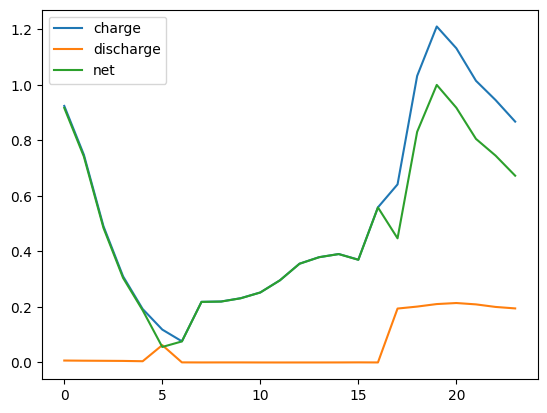

In [42]:
# Normalize Tobia's Nexus Output
hv_bus = str(89)
# Controlled charging
charge = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/Added_up_charge_2050.csv") # in MW
charge.rename(columns={'Unnamed: 0':'ts'}, inplace=True)
charge = charge.loc[(charge.ts<"2050-05-07 00:00:00") & (charge.ts>="2050-05-06 00:00:00")][['ts','peak',hv_bus]]
# Controlled discharging
discharge = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/EVBatt_power_hourly_2050_discharge_mapped.csv")
discharge = discharge.rename(columns={'Unnamed: 0':'ts'})
discharge = discharge.loc[(discharge.ts<"2050-05-07 00:00:00") & (discharge.ts>="2050-05-06 00:00:00")][['ts',hv_bus]]
# Find Netload Max
net= charge['89']-discharge['89']
day_max = net.max()
charge['normalized_profile'] = charge[hv_bus]/day_max
charge.index=range(24)
discharge['normalized_profile'] = discharge[hv_bus]/day_max
discharge.index=range(24)
net = charge['89']-discharge['89']
net_normalized = net/day_max
plt.plot(charge['normalized_profile'],label='charge')
plt.plot(discharge['normalized_profile'], label='discharge')
plt.plot(net_normalized, label='net')
plt.legend()

In [43]:
clustered = d.sort_values(by=['arr_time','parking_time'])
k = 25
group = np.arange(len(clustered)) % k
clustered['cluster']=group
path = "split_v1"

In [44]:
def opt_charge_profile(charge,discharge,net_normalized,cluster,emob_max_p,normalized_tot_e,cluster_i,path):
    t_list = list(range(24))
    e_list = list(cluster.event_index)
    tomatch_c = charge['normalized_profile']
    tomatch_d = discharge['normalized_profile']
    tomatch_net = net_normalized
    
    m = ConcreteModel()
    ############################
    # Set
    m.E = Set(initialize=e_list) # parking event set
    m.T = Set(initialize=t_list) # hour of the day
    ############################
    # Decision Variable
    m.charge_power = Var(m.E, m.T,within=NonNegativeReals,bounds=(0,1.5),initialize=0) 
    m.discharge_power = Var(m.E,m.T,within=NonNegativeReals,bounds=(0,1),initialize=0)
    
    m.is_parked = Var(m.E, m.T, within=Binary)
    m.is_charging = Var(m.E,m.T,within=Binary,initialize=0)
    m.is_discharging = Var(m.E,m.T,within=Binary,initialize=0)
    m.change = Var(m.E,m.T, within=Binary,initialize=0) # detect power direction change between 2 hours
    
    # Slack Variable
    m.charge_power_limit_s = Var(m.E, m.T, within=NonNegativeReals,initialize=0)
    m.discharge_power_limit_s = Var(m.E, m.T, within=NonNegativeReals, initialize=0)
    m.energy_surplus = Var(within=NonNegativeReals,bounds=(0,0.2*normalized_tot_e))
    m.energy_deficit = Var(within=NonNegativeReals,bounds=(0,0.2*normalized_tot_e))
    
    # Auxiliary Variable
    m.tot_charge_z = Var(m.T, within=NonNegativeReals, initialize=0)
    m.tot_discharge_z = Var(m.T, within=NonNegativeReals, initialize=0)
    ###########################
    # Parameters
    load_c = {t:tomatch_c[t] for t in t_list}
    m.charge_to_match = Param(m.T,initialize=load_c) # Normalized nexus profile
    
    load_d = {t:tomatch_d[t] for t in t_list}
    m.discharge_to_match = Param(m.T,initialize=load_d) # Normalized nexus profile
    
    load_net = {t:tomatch_net[t] for t in t_list}
    m.netload_to_match = Param(m.T,initialize=load_net) # Normalized net charge nexus profile
    
    capacity = {e:cluster.loc[e,'B']/emob_max_p for e in e_list}
    m.capacity = Param(m.E,initialize=capacity) # Normalized battery capacity
    
    max_power_dict = {e:cluster.loc[e,'normalized_chg_power'] for e in e_list} # max charge rate at normalized scale
    m.max_power = Param(m.E,initialize=max_power_dict) # unit kW
    
    parking_time_dict = {(e,t):cluster.loc[e,'hourly_time_dict'][t]/60 for e in e_list for t in t_list}
    m.parking_time = Param(m.E,m.T,initialize=parking_time_dict) # parking minutes within this hour
    
    next_trip_e_dict = {e:cluster.loc[e,'next_travel_TP1_consumption']/emob_max_p for e in e_list}
    m.next_trip_e = Param(m.E,initialize=next_trip_e_dict) # normalized energy next trip requires
    
    park_end_hour_dict = {e:cluster.loc[e,'park_end_hour'] for e in e_list}
    m.park_end_hour = Param(m.E,initialize=park_end_hour_dict) # Park End Hour
    
    park_end_day = {e:cluster.loc[e,'park_end_day'] for e in e_list}
    m.park_end_day = Param(m.E, initialize=park_end_day)# Park End Day
    
    SoE_dict = {(e,t):cluster.loc[e,'soe_init'][t]/emob_max_p for e in e_list for t in t_list}
    m.SoE_2d = Param(m.E,m.T,initialize=SoE_dict) # initial SoE profile
    
    SoE_init= {e:cluster.loc[e,'SoE_bc']/emob_max_p for e in e_list}
    m.SoE_init = Param(m.E,initialize=SoE_init) # initial SoE profile
    
    max_chg_e_dict = {e:cluster.loc[e,'max_chg_e']/emob_max_p for e in e_list}
    m.max_chg_e = Param(m.E,initialize=max_chg_e_dict) # max energy to charge for each event 
    
    m.unshifted_daily_energy = Param(initialize=normalized_tot_e)
    
    charge_status_change = {e:0 for e in e_list}
    m.charge_status_change = Param(m.E, initialize=charge_status_change) 
    
    ############################
    # enforce is_charging=1 if charging, 0 if discharging/no action
    def positive_charge_power_rule(m, e, t):
        return m.charge_power[e, t] <= 1000000 * m.is_charging[e, t]
    m.positive_charge_power_con = Constraint(m.E, m.T, rule=positive_charge_power_rule)
    # enforce is_discharging=1 if discharging, 0 if charging/no action
    def negative_charge_power_rule(m, e, t):
        return m.discharge_power[e, t] <= 1000000 * m.is_discharging[e, t]
    m.negative_charge_power_con = Constraint(m.E, m.T, rule=negative_charge_power_rule)
    # avoid simultaneous charge and discharge
    def non_simultaneous_rule(m, e, t):
        return m.is_charging[e, t] + m.is_discharging[e, t] <= 1
    m.non_simultaneous_con = Constraint(m.E, m.T, rule=non_simultaneous_rule)
    # enforce is_parked=1 if parking and ready to participate in grid, 0 if not available
    def parking_logic_constraint(m, e, t):
        M = 1000000  # Big M value, adjust as necessary
        return m.parking_time[e, t] <= M * m.is_parked[e, t]
    m.parking_logic = Constraint(m.E, m.T, rule=parking_logic_constraint)

    '''
    charging power limit
    '''
    def charge_power_limit_rule(m,e,t):
        return  m.charge_power[e, t] + m.charge_power_limit_s[e,t] == m.max_power[e] * m.is_charging[e,t]
    m.power_limit_c = Constraint(m.E, m.T, rule=charge_power_limit_rule)
    def discharge_power_limit_rule(m,e,t):
        return  m.discharge_power[e, t] + m.discharge_power_limit_s[e,t] == m.max_power[e] * m.is_discharging[e,t]
    m.power_limit_d = Constraint(m.E, m.T, rule=discharge_power_limit_rule)

    def parking_rule_c(m,e,t):
        if m.parking_time[e,t]==0:
            return m.charge_power[e,t]==0
        else:
            return Constraint.Skip
    m.parking_c = Constraint(m.E,m.T,rule=parking_rule_c)   
    def parking_rule_d(m,e,t):
        if m.parking_time[e,t]==0:
            return m.charge_power[e,t]==0
        else:
            return Constraint.Skip
    m.parking_d = Constraint(m.E,m.T,rule=parking_rule_d)  
    
    '''
    SoE non-negative and prepare for future trips constraints
    '''
    # update SoE for event e at hour t
    def SoE_update_rule(m,e,t):
        if t==0:
            return m.SoE_2d[e,t]
        else:
            return m.SoE_update[e,t-1]+(m.charge_power[e,t-1]-m.discharge_power[e,t-1])*m.parking_time[e,t-1]
    m.SoE_update=Expression(m.E,m.T,rule=SoE_update_rule)
    
    # Prepare for next trip:
    def next_trip_min_SoE_rule(m,e,t):
        if (m.park_end_day[e]==date) and (t==m.park_end_hour[e]):
            return m.SoE_update[e,t]>=m.next_trip_e[e]
        else:
            return Constraint.Skip  
    m.next_trip_min_SoE = Constraint(m.E,m.T,rule=next_trip_min_SoE_rule)
    
    # SoE shouldn't be negative:
    def SoE_nonnegative_rule(m,e,t):
        return m.SoE_update[e,t]>=0
    m.SoE_nonnegative = Constraint(m.E,m.T,rule=SoE_nonnegative_rule)
    
    # SoE does not exceed battery capacity
    def SoE_le_capacity_rule(m,e,t):
        return m.SoE_update[e,t]<=m.capacity[e]
    m.SoE_le_capacity = Constraint(m.E,m.T,rule=SoE_le_capacity_rule)
    
    '''
    Decreasing charging power by limiting current
    '''    
    def decrease_charge_power_rule_1(m,e,t):
        if t>0 and (m.parking_time[e,t]>=0):
            return (m.charge_power[e,t-1] - m.charge_power[e,t]) * m.is_charging[e,t-1]>=0
        else:
            return Constraint.Skip
    m.decreasing_charge_power = Constraint(m.E,m.T,rule=decrease_charge_power_rule_1)
        
    '''
    Avoid alternating charging direction
    '''
    def detect_change_rule(m,e,t):
        if t==0:
            return m.change[e,t]==0
        else:
            return (m.is_charging[e,t]+m.is_discharging[e,t])-(m.is_charging[e,t-1]+m.is_discharging[e,t-1]) <= 100000 * m.change[e,t]
    m.detect_change_1 = Constraint(m.E,m.T,rule=detect_change_rule)
    
    def detect_change_rule_2(m,e,t):
        if t==0:
            return m.change[e,t]==0
        else:
            return (m.is_charging[e,t]+m.is_discharging[e,t])-(m.is_charging[e,t-1]+m.is_discharging[e,t-1])>= -100000 * m.change[e,t]
    m.detect_change_2 = Constraint(m.E,m.T,rule=detect_change_rule_2)
    
    def avoid_alternating_rule(m,e):
        return sum(m.change[e,t] for t in m.T)
    m.change_direction = Expression(m.E,rule=avoid_alternating_rule)
    
    def avoid_adj_alternating_rule(m,e,t):
        if t>0:
            return (m.is_charging[e,t-1]-m.is_discharging[e,t-1])*(m.is_charging[e,t]-m.is_discharging[e,t])>=0
        else:
            return Constraint.Skip
    m.avoid_adj_alternating = Constraint(m.E,m.T,rule=avoid_adj_alternating_rule)
    
    '''
    Net Energy Matching
    '''
    # houlry charge energy requested from the grid for all EVs of shifted profile
    def hourly_tot_net_charge_energy_rule(m,t):
        return sum((m.charge_power[e,t]-m.discharge_power[e,t])*m.parking_time[e,t] for e in m.E)
    m.hourly_tot_net_charge_energy = Expression(m.T, rule=hourly_tot_net_charge_energy_rule)

    # Net charged energy for whole day of shifted profile
    def net_charge_daily_rule(m):
        return sum(m.hourly_tot_net_charge_energy[t] for t in m.T)
    m.shifted_daily_energy = Expression(rule=net_charge_daily_rule)

    # Match shifted daily required energy with the unshifted sum
    def match_daily_energy_rule(m):
        return m.shifted_daily_energy + m.energy_deficit ==m.unshifted_daily_energy + m.energy_surplus
    m.match_daily_energy = Constraint(rule=match_daily_energy_rule)
    
    '''
    Expression for hourly aggregated power
    '''
    # hourly charge power requested from the grid for all EVs
    def hourly_tot_charge_power_rule(m,t):
        return sum(m.charge_power[e,t] * m.is_charging[e,t] for e in m.E )
    m.hourly_tot_charge_power = Expression(m.T,rule=hourly_tot_charge_power_rule)
    def mask_tot_charge_z(m,t):
        return m.tot_charge_z[t]==m.hourly_tot_charge_power[t]
    m.tot_charge = Constraint(m.T, rule=mask_tot_charge_z)
    def hourly_tot_discharge_power_rule(m,t):
        return sum(m.discharge_power[e,t]* m.is_discharging[e,t] for e in m.E)
    m.hourly_tot_discharge_power = Expression(m.T, rule=hourly_tot_discharge_power_rule)
    def mask_tot_discharge_z(m,t):
        return m.tot_discharge_z[t]==m.hourly_tot_discharge_power[t]
    m.tot_discharge = Constraint(m.T, rule=mask_tot_discharge_z)
    def hourly_tot_net_charge_power_rule(m,t):
        return sum((m.charge_power[e,t]-m.discharge_power[e,t]) for e in m.E )
    m.houlry_tot_net_charge_power = Expression(m.T,rule=hourly_tot_net_charge_power_rule)
    
    ###########################
    # Objective 
    def objective_rule(m):
        return sum((m.charge_to_match[t]-m.tot_charge_z[t])**2 for t in m.T) + sum((m.discharge_to_match[t]-m.tot_discharge_z[t])**2 for t in m.T)+ sum(1000*(m.charge_power_limit_s[e,t]+m.discharge_power_limit_s[e,t]) for e in m.E for t in m.T)
        #sum((m.charge_to_match[t]-m.hourly_tot_charge_power[t])**2 for t in m.T) + sum((m.discharge_to_match[t]-m.hourly_tot_discharge_power[t])**2 for t in m.T)+ sum(1000*(m.charge_power_limit_s[e,t]+m.discharge_power_limit_s[e,t]) for e in m.E for t in m.T)
    m.objective = Objective(rule=objective_rule, sense=minimize)
    ###########################
    # Solve model
    solver = SolverFactory('gurobi')
    # solver.options['tol'] = 0.0001
    solver.solve(m,tee=True)   #,keepfiles=True,logfile="match_profile_log.log")
    # Save results
    ch_dict = {(e, t): m.charge_power[e, t].value*emob_max_p for e in m.E for t in m.T} # Denormalize back to normal power value in kW
    dis_dict = {(e,t):m.discharge_power[e,t].value*emob_max_p for e in m.E for t in m.T}
    ch = pd.Series(ch_dict).unstack()
    ch.to_csv(f'{path}/369_0_cluster_{cluster_i}_charge.csv')
    dis = pd.Series(dis_dict).unstack()
    dis.to_csv(f'{path}/369_0_cluster_{cluster_i}_discharge.csv')
    return 0

In [ ]:
# Normalize the mobility aggregated charge power, calculate min, max, sum of power if there were EVs charging in the cluster then optimize this cluster's charging behavior to fit the curve
for i in range(9,k):
    
    cluster = clustered[clustered['cluster']==i]
    emob_agg_e = [sum(x) for x in zip(*cluster['charge_energy_list'])] # energy in kWh
    emob_agg_p = [sum(x) for x in zip(*cluster['charge_power_list'])] # power in kW
    
    emob_max_p, emob_min_p,emob_tot_p = max(emob_agg_p), min(emob_agg_p), sum(emob_agg_p)
    print("Mobility data peak power:",emob_max_p,"Mobility data minimal power:",emob_min_p,"Mobility data total power:",emob_tot_p)

    emob_max_e, emob_min_e, emob_tot_e= max(emob_agg_e), min(emob_agg_e),sum(emob_agg_e)
    print("Mobility data peak energy:",emob_max_e,"Mobility data minimal energy:",emob_min_e,"Mobility data total energy:",emob_tot_e)
    
    if emob_max_p!=0:
        emob_agg_p_norm =  [p/emob_max_p for p in emob_agg_p]
        plt.figure(figsize=(10,6))
        plt.plot(emob_agg_p,label='power')
        plt.plot(emob_agg_e,label='energy')
        plt.legend()
        plt.savefig(f'{path}/369_9_cluster_{i}_agg_p_e.png')
        cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p
        normalized_tot_e = emob_tot_e/emob_max_p
        opt_res_code = opt_charge_profile(charge,discharge,net_normalized,cluster,emob_max_p,normalized_tot_e,i,path)

    else:
        index = list(cluster['event_index'])
        T = list(range(24))
        res_dict = {(e, t):0 for e in index for t in T} # Denormalize back to normal power value in kW
        # Convert the dictionary into a multi-index series to facilitate unstacking
        res = pd.Series(res_dict).unstack()
        # Save the restructured data to CSV
        res.to_csv(f'{path}/369_0_cluster_{i}.csv')
        

Mobility data peak power: 332.0 Mobility data minimal power: 0 Mobility data total power: 3423.0
Mobility data peak energy: 320.9166666666666 Mobility data minimal energy: 0.9333333333333333 Mobility data total energy: 3563.5000000000005


/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/2739078675.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpznmv72gs.pyomo.lp
Reading time = 1.30 seconds
x1: 356078 rows, 247347 columns, 1135960 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 356078 rows, 247347 columns and 1135960 nonzeros
Model fingerprint: 0xed68153e
Model has 48 quadratic objective terms
Model has 59296 quadratic constraints
Variable types: 123699 continuous, 123648 integer (123648 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-04, 1e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [4e-04, 1e+01]
Presolve removed 272398 rows and 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/2739078675.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp3syj5el7.pyomo.lp
Reading time = 1.29 seconds
x1: 355965 rows, 247347 columns, 1136694 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 355965 rows, 247347 columns and 1136694 nonzeros
Model fingerprint: 0xe26ab278
Model has 48 quadratic objective terms
Model has 59296 quadratic constraints
Variable types: 123699 continuous, 123648 integer (123648 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-04, 1e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [8e-04, 9e+00]
Presolve removed 272062 rows and 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/2739078675.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpodoreeh0.pyomo.lp
Reading time = 1.26 seconds
x1: 355922 rows, 247347 columns, 1134418 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 355922 rows, 247347 columns and 1134418 nonzeros
Model fingerprint: 0x5d4aee40
Model has 48 quadratic objective terms
Model has 59296 quadratic constraints
Variable types: 123699 continuous, 123648 integer (123648 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-04, 1e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [4e-04, 1e+01]
Presolve removed 272109 rows and 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/2739078675.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpqri2ijv8.pyomo.lp
Reading time = 1.28 seconds
x1: 356008 rows, 247347 columns, 1133486 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 356008 rows, 247347 columns and 1133486 nonzeros
Model fingerprint: 0xf3f70ec8
Model has 48 quadratic objective terms
Model has 59296 quadratic constraints
Variable types: 123699 continuous, 123648 integer (123648 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-04, 1e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [5e-04, 1e+01]
Presolve removed 272270 rows and 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/2739078675.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpa0wp2cgf.pyomo.lp
Reading time = 1.28 seconds
x1: 356394 rows, 247347 columns, 1127374 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 356394 rows, 247347 columns and 1127374 nonzeros
Model fingerprint: 0x0bbaea81
Model has 48 quadratic objective terms
Model has 59296 quadratic constraints
Variable types: 123699 continuous, 123648 integer (123648 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-04, 1e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [5e-04, 9e+00]
Presolve removed 64 rows and 0 co

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/2739078675.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmph70y8ng4.pyomo.lp
Reading time = 1.27 seconds
x1: 356368 rows, 247347 columns, 1123950 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 356368 rows, 247347 columns and 1123950 nonzeros
Model fingerprint: 0x7b30a0bd
Model has 48 quadratic objective terms
Model has 59296 quadratic constraints
Variable types: 123699 continuous, 123648 integer (123648 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-04, 1e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [4e-04, 1e+01]
Presolve removed 273321 rows and 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/2739078675.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpxhb88863.pyomo.lp
Reading time = 1.25 seconds
x1: 355638 rows, 247347 columns, 1140624 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 355638 rows, 247347 columns and 1140624 nonzeros
Model fingerprint: 0xbf0fecb2
Model has 48 quadratic objective terms
Model has 59296 quadratic constraints
Variable types: 123699 continuous, 123648 integer (123648 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-04, 1e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [5e-04, 1e+01]
Presolve removed 271267 rows and 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/2739078675.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpajrkxwzx.pyomo.lp
Reading time = 1.26 seconds
x1: 355824 rows, 247347 columns, 1137116 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 355824 rows, 247347 columns and 1137116 nonzeros
Model fingerprint: 0xc195a1ab
Model has 48 quadratic objective terms
Model has 59296 quadratic constraints
Variable types: 123699 continuous, 123648 integer (123648 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-04, 1e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [3e-04, 9e+00]
Presolve removed 271817 rows and 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/2739078675.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp8ya_wxp7.pyomo.lp
Reading time = 1.30 seconds
x1: 356019 rows, 247347 columns, 1134388 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 356019 rows, 247347 columns and 1134388 nonzeros
Model fingerprint: 0x3cf6ab8a
Model has 48 quadratic objective terms
Model has 59296 quadratic constraints
Variable types: 123699 continuous, 123648 integer (123648 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-04, 1e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [4e-04, 1e+01]
Presolve removed 272243 rows and 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_29897/2739078675.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp87eter2a.pyomo.lp
Reading time = 1.27 seconds
x1: 355953 rows, 247347 columns, 1134736 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 355953 rows, 247347 columns and 1134736 nonzeros
Model fingerprint: 0xee7290cc
Model has 48 quadratic objective terms
Model has 59296 quadratic constraints
Variable types: 123699 continuous, 123648 integer (123648 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-04, 1e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [3e-04, 9e+00]
Presolve removed 272184 rows and 

In [ ]:
agg_e = [sum(x) for x in zip(*d['charge_energy_list'])] # energy in kWh
agg_p = [sum(x) for x in zip(*d['charge_power_list'])] # power in kW
max_p,min_p,tot_p = max(agg_p), min(agg_p), sum(agg_p)
max_e, min_e,tot_e= max(agg_e), min(agg_e),sum(agg_e)
print(tot_e)

In [ ]:
path = 'split_v1'
concat_charge = pd.DataFrame()
concat_discharge = pd.DataFrame()
for i in [0]:# range(k):
    charge_i = pd.read_csv(f'{path}/369_0_cluster_{i}_charge.csv')
    concat_charge = pd.concat([concat_charge,charge_i],axis=0)
    discharge_i = pd.read_csv(f'{path}/369_0_cluster_{i}_discharge.csv')
    concat_discharge = pd.concat([concat_discharge,discharge_i],axis=0)
    
concat_charge = concat_charge.rename(columns={'Unnamed: 0':'event_index'})
concat_discharge = concat_discharge.rename(columns={'Unnamed: 0':'event_index'})
concat_res = concat_charge-concat_discharge
concat_charge.to_csv(f'{path}/concat_charge_power_all.csv')
concat_discharge.to_csv(f'{path}/concat_dicharge_power_all.csv')
concat_res.to_csv(f'{path}/concat_net_power_all.csv')
concat_sum = concat_res.sum()[1:].sum()
concat_max = concat_res.sum()[1:].max()
plt.figure(figsize=(10,6))
plt.plot(concat_res.sum()[1:]/concat_max,label='optimized net charging normalized')
plt.plot(net,label='nexus net charging normalized')
plt.plot(concat_charge.sum()[1:].sum()/concat_max, label='optimized charge normalized')
plt.plot(charge['normalized_profile'],label='nexus charge normalized')
plt.plot(concat_discharge.sum()[1:].sum()/concat_max, label='optimized discharege normalized')
plt.plot(discharge['normalized_profile'],label='nexus discharge normalized')
plt.legend()
plt.savefig(f'{path}/optimized_norm_power_vs_nexus.png')
plt.show()


In [ ]:
res_p = concat_res.sum()[1:]
plt.plot(res_p,label='optimized_power_profile')
plt.plot(agg_p, label='mobility_data_power_profile')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_power_profile.png')

In [15]:
concat_res

,event_index,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0
3,8135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,1097974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1284,1098554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1285,1098578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1286,1098956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
concat_res = concat_res.set_index('event_index').sort_index()
time = pd.DataFrame(d['hourly_time_dict'].sort_index())
event_e = concat_res.apply(lambda row: [row[col]*time.at[row.name,'hourly_time_dict'][col]/60 for col in range(24)],axis=1)

In [ ]:
e = pd.DataFrame(event_e.tolist())
e.set_index(concat_res.index,inplace=True)
res_e = pd.Series(e.sum(),name='agg_e')
res_e_sum = res_e.sum()

In [ ]:
res_p = concat_res.sum()[1:]
# plt.plot(res_p,label='optimized_power_profile')
plt.plot(res_e,label='optimized_energy_profile')
plt.plot(agg_e,label='mobility_data_energy_profile')
plt.text(5,7500,f'mobility:{tot_e:.2f}')
plt.text(5,7000,f'optimized:{res_e_sum:.2f}')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_energy_profile.png')